In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D
import keras
import tensorflow as tf
def Percentage_Accuracy(y_true, y_pred):
    diff = keras.backend.abs(y_true-y_pred)
    correct = keras.backend.less(diff,0.05) 
    return keras.backend.mean(correct) 

In [17]:
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [10]:
config = tf.ConfigProto( device_count = {'GPU': 0 } )
sess = tf.Session(config= config )
keras.backend.set_session(sess)

In [11]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&outputsize=full&apikey=EQ50I9Q6ZC3B43AX"
r = requests.get(url)
data = r.json()

#print(data)

In [112]:
df = pd.DataFrame.from_dict(list(data.values())[1],orient='index').reset_index()
# df = df.rename(columns={'index':'time' ,'1. open': 'open', '2. high':'high' , '3. low' : 'low', '4. close': 'close', '5. volume': 'volume'})
df = df.rename(columns={'index':'time' ,'1. open': 'open', '2. high':'high' , '3. low' : 'low', '4. close': 'close','5. adjusted close': 'adjclose', '6. volume': 'volume'})

df = df.set_index(pd.to_datetime(df.time))
df.sort_index(inplace=True)
df = df.resample('D').pad()
df.close = df.close.astype('float')
split_size = int(len(df)-400)

for a in ('time','7. dividend amount','8. split coefficient'):
    df = df.drop(a,axis= 1)
    
df


,open,high,low,close,adjclose,volume
time,,,,,,
1999-11-01,98.5,98.81,96.37,96.75,59.358271344,9551800
1999-11-02,96.75,96.81,93.69,94.81,58.1680383062,11105400
1999-11-03,95.87,95.94,93.5,94.37,57.8980885451,10369100
1999-11-04,94.44,94.44,90.0,91.56,56.1740912068,16697600
1999-11-05,92.75,92.94,90.19,90.25,55.3703771452,13737600
...,...,...,...,...,...,...
2021-08-30,139.5,139.88,138.815,138.97,138.97,1995526
2021-08-31,139.54,140.94,138.95,140.34,140.34,4235101
2021-09-01,139.98,140.0699,139.19,139.30,139.3,2474544


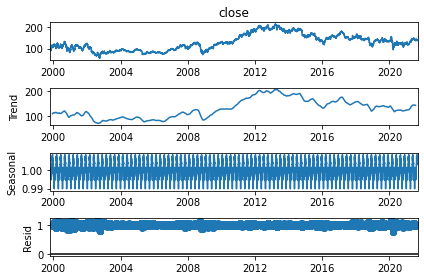

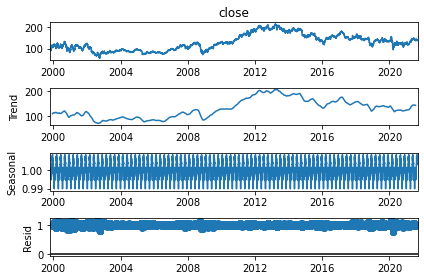

In [113]:
decompose_result = seasonal_decompose(df['close'],model='multiplicative',period = 90)
decompose_result.plot()

In [114]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = 'D'
# Set the value of Alpha and define m (Time Period)
m = 365
alpha = 1/(2*m)

A:\Anaconda\envs\ML_GPU\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
A:\Anaconda\envs\ML_GPU\lib\site-packages\statsmodels\tsa\holtwinters\model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
A:\Anaconda\envs\ML_GPU\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


<AxesSubplot:title={'center':'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='time'>

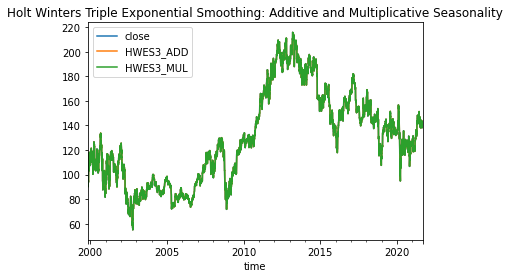

In [119]:
df['HWES3_ADD'] = ExponentialSmoothing(df['close'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df['HWES3_MUL'] = ExponentialSmoothing(df['close'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df[['close','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')


In [13]:
def set_maker(arr,sc):
    scaled_set = sc.transform(arr)# Creating a data structure with 60 time-steps and 1 output
    X = []
    y = []
    for i in range(90, len(arr)):
        X.append(scaled_set[i-90:i, 0])
        y.append(scaled_set[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X,y

In [120]:
df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'HWES3_ADD',
       'HWES3_MUL'],
      dtype='object')

In [14]:
# training_set_open = df.iloc[:int(len(df)*0.7), 1:2].values
# test_set_open = df.iloc[int(len(df)*0.7):, 1:2].values
# training_set_close = df.iloc[:int(len(df)*0.7), 4:5].values
# test_set_close = df.iloc[int(len(df)*0.7):, 4:5].values

training_set_open = df.iloc[:split_size, 0:1].values
test_set_open = df.iloc[split_size:, 0:1].values

training_set_open = df.iloc[:split_size, 1:2].values
test_set_open = df.iloc[split_size:, 1:2].values

training_set_high = df.iloc[:split_size, 2:3].values
test_set_high = df.iloc[split_size:, 2:3].values

training_set_low = df.iloc[:split_size, 3:4].values
test_set_low = df.iloc[split_size:, 3:4].values

training_set_close = df.iloc[:split_size, 4:5].values
test_set_close = df.iloc[split_size:, 4:5].values

training_set_vol = df.iloc[:split_size, 5:6].values
test_set_vol = df.iloc[split_size:, 5:6].values

In [15]:
sc_open = MinMaxScaler(feature_range = (-1, 1))
sc_close = MinMaxScaler(feature_range = (-1, 1))
sc_high = MinMaxScaler(feature_range = (-1, 1))
sc_vol = MinMaxScaler(feature_range = (-1, 1))
sc_low = MinMaxScaler(feature_range = (-1, 1))

sc_open.fit(training_set_open)
sc_high.fit(training_set_high)
sc_low.fit(training_set_low)
sc_vol.fit(training_set_vol)
sc_close.fit(training_set_close)

open_x,close_y = set_maker(training_set_open,sc_open)
high_x,close_y = set_maker(training_set_high,sc_high)
low_x,close_y = set_maker(training_set_low,sc_low)
vol_x,close_y = set_maker(training_set_vol,sc_vol)
close_x,close_y = set_maker(training_set_close,sc_close)

train_x = np.concatenate((open_x,high_x,low_x,vol_x,close_x),axis=2)

test_open_x,test_close_y = set_maker(test_set_open,sc_open)
test_high_x,test_close_y = set_maker(test_set_high,sc_high)
test_low_x,test_close_y = set_maker(test_set_low,sc_low)
test_vol_x,test_close_y = set_maker(test_set_vol,sc_close)
test_close_x,test_close_y = set_maker(test_set_close,sc_close)
test_x = np.concatenate((test_open_x,test_high_x,test_low_x,test_vol_x,test_close_x),axis=2)


In [25]:
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 60, return_sequences = True, input_shape = (train_x.shape[1], train_x.shape[2])))
model.add(Conv1D(60,31,activation='relu'))
model.add(LSTM(units = 30, return_sequences = True))
model.add(Conv1D(30,16,activation='relu'))
model.add(LSTM(units = 15))
model.add(Dropout(0.2))# Adding the output layer
model.add(Dense(units = 1))

opt = keras.optimizers.Adamax()
lossfunction = keras.losses.mse
# Compiling the RNN
model.compile(optimizer = opt, loss = lossfunction, metrics=[Percentage_Accuracy])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 60, 60)            15840     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 60)            111660    
_________________________________________________________________
lstm_22 (LSTM)               (None, 30, 30)            10920     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 15, 30)            14430     
_________________________________________________________________
lstm_23 (LSTM)               (None, 15)                2760      
_________________________________________________________________
dropout_21 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 16        
Total para

In [28]:
# Fitting the RNN to the Training set
model.fit(train_x, close_y, epochs = 30, batch_size = 60)

Epoch 1/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0083 - Percentage_Accuracy: 0.4715
Epoch 2/30
4978/4978 [==============================] - 7s 1ms/step - loss: 0.0081 - Percentage_Accuracy: 0.4628
Epoch 3/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0080 - Percentage_Accuracy: 0.4753
Epoch 4/30
4978/4978 [==============================] - 7s 1ms/step - loss: 0.0079 - Percentage_Accuracy: 0.4898
Epoch 5/30
4978/4978 [==============================] - 7s 1ms/step - loss: 0.0079 - Percentage_Accuracy: 0.4783
Epoch 6/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0078 - Percentage_Accuracy: 0.4805
Epoch 7/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0084 - Percentage_Accuracy: 0.4745
Epoch 8/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0077 - Percentage_Accuracy: 0.4936
Epoch 9/30
4978/4978 [==============================] - 6s 1ms/step - loss: 0.0077 - Percentage_

In [29]:
predicted_stock_price = model.predict(test_x)
predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)

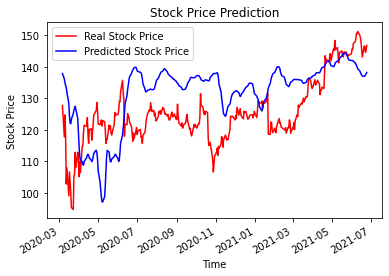

In [30]:
vector = np.vectorize(np.float)
t_pred = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], ))
acc_val = vector(df.loc[(split_size+70):, 'close'].values)
time = df.loc[(split_size+70):, 'time'].values
plt.plot(time,acc_val, color = 'red', label = 'Real Stock Price')
plt.plot(time,t_pred, color = 'blue', label = 'Predicted Stock Price')
plt.gcf().autofmt_xdate()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(acc_val,predicted_stock_price)

6.232243232495858